## 현재날씨 : 지역, 상태, 온도, 체감온도, 습도, 풍향

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
 
source = requests.get('https://www.weather.go.kr/weather/observation/currentweather.jsp')
soup = BeautifulSoup(source.content,"html.parser")
 
table = soup.find('table',{'class':'table_develop3'})
data = []
 
print("#"*50)

for tr in table.find_all('tr'):
    tds = list(tr.find_all('td'))
    for td in tds:
        if td.find('a'):
            w_local = td.find('a').text
            w_status = tds[1].text
            w_temp = tds[5].text
            w_body_temp = tds[7].text
            w_humidity = tds[10].text
            w_wind = tds[11].text
            print("{0:<7} {1:<7} {2:<7} {3:<7} {4:<7} {5:<7} ".format(w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind))
            data.append([w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind])
            
print("#"*50)
 
print(data)

##################################################
강릉              0.4     -2.9    31      남서      
강진군             -0.4    -0.4    84      정온      
강화              -6.8    -6.8    90      동남동     
거제              0.8     0.8     82      정온      
거창              -1.7    -1.7    81      정온      
경주시             -1.4    -1.4    80      남동      
고산              7.2     4.2     61      북서      
고창              -0.3    -0.3    87      정온      
고창군             0.4     0.4     84      정온      
고흥              0.6     0.6     80      정온      
광양시             2.2     2.2     66      서       
광주      흐림      1.3     1.3     82      정온      
구미              -1.4    -1.4    83      정온      
군산              0.7     0.7     86      정온      
금산              -0.4    -0.4    89      정온      
김해시             -0.8    -0.8    66      서북서     
남원              -0.2    -0.2    79      정온      
남해              1.7     1.7     73      서남서     
대관령             -8.9    -15.0   53      북서      
대구      구름많음    -1

In [2]:
with open('weather.csv','w', encoding='utf-8-sig') as f:
    f.write('지역, 상태, 온도, 체감온도, 습도, 풍향\n')
    for i in data:
        f.write('{0},{1},{2},{3},{4},{5}\n'.format(i[0],i[1],i[2],i[3],i[4],i[5]))

In [3]:
df = pandas.read_csv('weather.csv', index_col='지역' , encoding='utf-8-sig')

#### 여기 안 함

In [4]:
city_df = df.loc[['서울','인천','대전','대구','광주','부산','울산']]

print(city_df)

city_df.to_csv('현재날씨.csv',encoding='utf-8-sig')

      상태   온도   체감온도   습도   풍향
지역                            
서울  구름조금 -7.3  -11.0   88  동북동
인천    박무 -4.8   -4.8   82   남동
대전    박무 -2.3   -2.3   91   정온
대구  구름많음 -1.3   -1.3   82   정온
광주    흐림  1.3    1.3   82   정온
부산    맑음  2.5    2.5   60  북북서
울산    맑음  2.3    2.3   65   북서


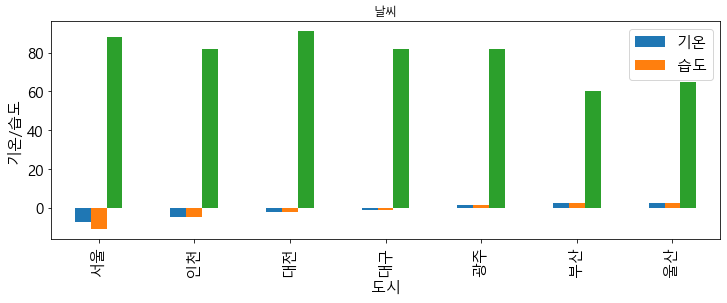

In [5]:
# 그래프
font_name = mpl.font_manager.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
mpl.rc('font',family=font_name)
 
ax = city_df.plot(kind='bar',title='날씨',figsize=(12,4),legend=True,fontsize=15)
ax.set_xlabel('도시',fontsize=15)
ax.set_ylabel('기온/습도',fontsize=15)
ax.legend(['기온','습도'],fontsize=15)
 
plt.show()

#### 여기부터

### DB 연결

In [6]:
!pip install cx_Oracle
import cx_Oracle
from bs4 import BeautifulSoup
import requests as req
from pprint import pprint
!pip install pymssql
import pyodbc

### Oracle DB : data 생성

In [7]:
dsn = cx_Oracle.makedsn('project-db-stu.ddns.net',1524,'xe')
url = "https://www.weather.go.kr/weather/observation/currentweather.jsp"
material = req.get(url)
soup = BeautifulSoup(material.text, 'html.parser')
conn = cx_Oracle.connect('cgi_8_1_1216','smhrd1',dsn)

with conn :
    cur = conn.cursor()
    drop_table = """
                    BEGIN
                        EXECUTE IMMEDIATE 'DROP TABLE t_live_weather';
                    EXCEPTION
                        WHEN OTHERS THEN
                            IF SQLCODE != -942 THEN
                                RAISE;
                            END IF;
                    END;
                """
    cur.execute(drop_table)
    
    drop_seq = """
                    BEGIN
                        EXECUTE IMMEDIATE 'DROP SEQUENCE fc_seq';
                    EXCEPTION
                        WHEN OTHERS THEN
                        IF SQLCODE != -2289 THEN
                            RAISE;
                        END IF;
                    END;
                """
    cur.execute(drop_seq)
    
    create_table ="""
                    create table t_live_weather(
                        w_index number(4) primary key,
                        w_region varchar2(20),
                        w_status varchar2(20),
                        w_temp number(5),
                        w_body_temp number(5),
                        w_humidity number(5),
                        w_wind varchar2(20)                        
                    )
                """
    cur.execute(create_table)
    
    cur.execute("create sequence fc_seq")
        
    for tr in table.find_all('tr'):
        tds = list(tr.find_all('td'))
        for td in tds:
            if td.find('a'):
                w_local = td.find('a').text
                w_status = tds[1].text
                w_temp = tds[5].text
                w_body_temp = tds[7].text
                w_humidity = tds[10].text
                w_wind = tds[11].text
                print("{0:<7} {1:<7} {2:<7} {3:<7} {4:<7} {5:<7} ".format(w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind))
                data.append([w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind])
        
        # 데이터 삽입
        insert_data = """
                        insert into t_live_weather(w_index, w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind)
                        values(fc_seq.nextval, :1, :2, :3, :4, :5, :6)
                    """
        cur.execute(insert_data, (w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind))
    conn.commit()

    cur.execute("select * from t_live_weather") #데이터 조회 => 데이터 추가됐는지 확인
    pprint(cur.fetchall())

강릉              0.4     -2.9    31      남서      
강진군             -0.4    -0.4    84      정온      
강화              -6.8    -6.8    90      동남동     
거제              0.8     0.8     82      정온      
거창              -1.7    -1.7    81      정온      
경주시             -1.4    -1.4    80      남동      
고산              7.2     4.2     61      북서      
고창              -0.3    -0.3    87      정온      
고창군             0.4     0.4     84      정온      
고흥              0.6     0.6     80      정온      
광양시             2.2     2.2     66      서       
광주      흐림      1.3     1.3     82      정온      
구미              -1.4    -1.4    83      정온      
군산              0.7     0.7     86      정온      
금산              -0.4    -0.4    89      정온      
김해시             -0.8    -0.8    66      서북서     
남원              -0.2    -0.2    79      정온      
남해              1.7     1.7     73      서남서     
대관령             -8.9    -15.0   53      북서      
대구      구름많음    -1.3    -1.3    82      정온      
대전      박무      -2.3